

#### Following project was realised within the course of Machine Learning and cuda in PHD school at AGH. Goal of the project was to create an model to forecast lipophilicity of given molecules using graph neural networks.

In [ ]:
import torch
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
!pip install rdkit

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html


#### First, let us import data

In [ ]:
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root=".", name="lipo")

In [ ]:
print(data[0])

Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])


#### Looking into a sample of data, we can see, that each element is a graph. This graph represents a molecule. Our goal would be to forecast lipophilicity of the molecule. Lipophilicity is ability of a chemical compound to dissolve in fats, oils, lipids, and non-polar solvents such as hexane or toluene. Lipophilicity of the particular molecule is contained in parameter y.

#### In x matrix we can find parameters related to the verticies of the graph,
#### edge_index encodes egdes beetween those vericies and in edge_attr we can find parameters related to edges.

#### String smiles encodes this molecule in chemical notation and the information which could be provided from this notation is alredy provide in x and egde_attr, thus we would not make use of this part of the data.

#### Using torch.geometric let us then construct and train our graph neural network.

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
embedding_size = 16
dense_neurons = 256

class GCN(torch.nn.Module):
    def __init__(self):

        super(GCN, self).__init__()

        self.initial_conv = GCNConv(data.num_features, embedding_size*8)
        self.conv1 = GCNConv(embedding_size*8, embedding_size*4)
        self.conv2 = GCNConv(embedding_size*4, embedding_size*2)
        self.conv3 = GCNConv(embedding_size*2, embedding_size)

        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, 1)

    def forward(self, x, edge_index, edge_attr, batch_index):

        model = self.initial_conv(x, edge_index, edge_attr)
        model = F.tanh(model)

        model = self.conv1(model, edge_index, edge_attr)
        model = F.relu(model)
        model = self.conv2(model, edge_index, edge_attr)
        model = F.relu(model)
        model = self.conv3(model, edge_index, edge_attr)
        model = F.relu(model)

        #Aplying agragated global max and mean pooling
        model = torch.cat([global_max_pool(model, batch_index),
                            global_mean_pool(model, batch_index)], dim=1)

        model = torch.relu(self.linear1(model))
        model = self.linear2(model)

        return model

model = GCN()
print(model)


GCN(
  (initial_conv): GCNConv(9, 128)
  (conv1): GCNConv(128, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 16)
  (linear1): Linear(in_features=32, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
from torch_geometric.loader import DataLoader
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import copy


model_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Dividing data into train and test data
data_size = len(data)
batch_size = 16
train_data = DataLoader(data[int(data_size * 0.2):],
                    batch_size=batch_size, shuffle=True)


def train(data, idx):
    for batch in data:
      batch.to(device)
      optimizer.zero_grad()
      pred = model(batch.x.float(), batch.edge_index, batch.edge_attr[:, idx % 3].float(), batch.batch)
      loss = model_loss(pred, batch.y)
      loss.backward()
      optimizer.step()
    return loss

best_epoch = 0
best_mse = 10
train_data_losses = []
test_data_losses = []
for epoch in range(2001):
    loss = train(train_data, epoch)
    train_data_losses.append(loss)


    if epoch % 50 == 0:

      test_data = DataLoader(data[:int(data_size * 0.2)], batch_size=1, shuffle=True)
      predictions = []
      y_values = []
      for batch in test_data:
            batch.to(device)
            prediction = model(batch.x.float(), batch.edge_index, batch.edge_attr[:, 1].float(), batch.batch)
            predictions.append(prediction.item())
            y_values.append(batch.y.item())

      predictions = np.array(predictions)
      real_values = np.array(y_values)
      test_data_mse = mean_squared_error(predictions,real_values)
      test_data_losses.append(test_data_mse)
      print(f"In epoch {epoch} loss on train data equals {loss} and the loss on test data equals {test_data_mse} ")
      if best_mse > test_data_mse:
        best_model = copy.deepcopy(model)
        best_mse = copy.deepcopy(test_data_mse)
        best_epoch = copy.deepcopy(epoch)

print(test_data_losses)
print(f"Epoch {best_epoch} had the least mean squared error")

In epoch 0 loss on train data equals 0.9170002937316895 and the loss on test data equals 1.44954630430697 
In epoch 50 loss on train data equals 1.2191112041473389 and the loss on test data equals 1.2370666452299266 
In epoch 100 loss on train data equals 0.6215745806694031 and the loss on test data equals 0.8504346906179641 
In epoch 150 loss on train data equals 0.7076681852340698 and the loss on test data equals 1.0641250208498516 
In epoch 200 loss on train data equals 0.6153231263160706 and the loss on test data equals 0.8258590413245745 
In epoch 250 loss on train data equals 0.7746205925941467 and the loss on test data equals 0.8036137799979818 
In epoch 300 loss on train data equals 1.6819318532943726 and the loss on test data equals 0.8645802163197095 
In epoch 350 loss on train data equals 0.4743208587169647 and the loss on test data equals 0.7236513306240387 
In epoch 400 loss on train data equals 1.1455411911010742 and the loss on test data equals 0.739870257665996 
In epoc

#### Blue plot show us mean squared error on train data, and the orange one is an error for test data. Clearly we can see that this model wouldnt get any better if we would train him further.



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

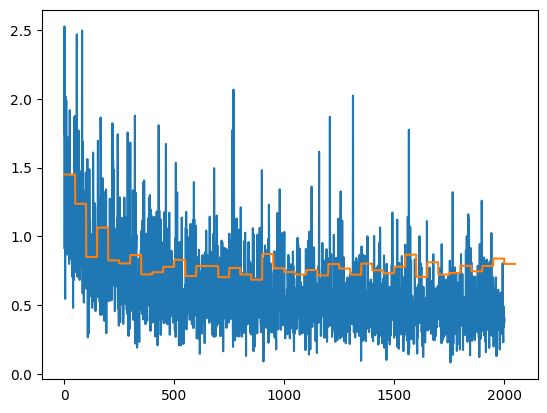

In [ ]:
import matplotlib.pyplot as plt

test_data_losses
test_data_losses_long = []
for i in range(len(test_data_losses)):
  for j in range(50):
    test_data_losses_long.append(test_data_losses[i])

plt.plot(list(map(lambda x: x.item(), train_data_losses)))
plt.plot(list(map(lambda x: x.item(), test_data_losses_long)))
plt

#### Since we saved model with the smallest error while learning we could see the results and compare it to the average-based model.

In [ ]:
test_data = DataLoader(data[:int(data_size * 0.2)], batch_size=1, shuffle=True)
predictions = []
y_values = []
for batch in test_data:
            batch.to(device)
            prediction = best_model(batch.x.float(), batch.edge_index, batch.edge_attr[:, 1].float(), batch.batch)
            predictions.append(prediction.item())
            y_values.append(batch.y.item())

predictions = np.array(predictions)
real_values = np.array(y_values)

df = pd.DataFrame()
df["real values"] = real_values
df["predictions"] = predictions
df

,real values,predictions
0,0.50,1.406229
1,1.60,1.677708
2,-1.17,-0.038724
3,-0.45,0.780703
4,1.96,1.836084
...,...,...
835,1.26,1.812793
836,2.83,1.511309
837,1.34,1.420708
838,0.86,1.146283


#### Calculating mean squared error and comparing it to average-based model


In [ ]:
from statistics import mean

test_data_mse = mean_squared_error(predictions,real_values)
mean = mean(real_values)
means = np.ones(len(real_values))*mean
mean_error = mean_squared_error(means, real_values)

print(f"For the best model that we got, mean squared error is equal to {test_data_mse}, when average-based model would have mse at value {mean_error}.")

For the best model that we got, mean squared error is equal to 0.6852791046673427, when average-based model would have mse at value 1.3840966787220848.


<Axes: xlabel='real values', ylabel='predictions'>

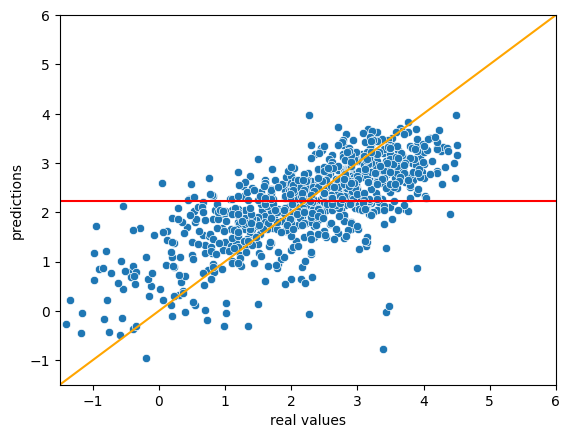

In [ ]:
import seaborn as sns
plt = sns.scatterplot(data=df, x="real values", y="predictions")
plt.axline(xy1 = (0,0), xy2=(1,1), color = "orange")
plt.axhline(y = mean, color= "r")
plt.set(xlim=(-1.5, 6))
plt.set(ylim=(-1.5, 6))
plt